# This video is sponsored by ADA! An analysis of sponsorships on YouTube

## Table of Contents

1. [Imports](#Imports)
2. [Process Links in Video Descriptions](#Process-Links-in-Video-Descriptions) [see [videos_links.ipynb](processing/videos_links.ipynb)]
    1. [Extract Links from Video Descriptions](#Extract-Links-from-Video-Descriptions)
    2. [Analyse Shortened URLs](#Analyse-Shortened-URLs)
    3. [Resolve Shortened URLs](#Resolve-Shortened-URLs)
        1. [Resolve Bitly URLs](#Resolve-Bitly-URLs) [also see [resolve_bitly_links.ipynb](processing/resolve_bitly_links.ipynb)]
        2. [Resolve Google URLs](#Resolve-Google-URLs) [also see [resolve_google_links.ipynb](processing/resolve_google_links.ipynb)]
    4. [Resolve URLs in the Metadata Dataset](#Resolve-URLs-in-the-Metadata-Dataset)
3. [Detect Sponsorship Theme in Video Descriptions](#Detect-Sponsorship-Theme-in-Video-Descriptions) [see [videos_sponsorship.ipynb](processing/videos_sponsorship.ipynb)]
    1. [Define the Theme Detection Function](#Define-the-Theme-Detection-Function)
    2. [Apply the Theme Detection Function on the Dataset](#Apply-the-Theme-Detection-Function-on-the-Dataset)
    3. [Analyse the Sponsorship Scores](#Analyse-the-Sponsorship-Scores)

## Imports

In [ ]:
# FINDSPARK
import findspark
findspark.init()

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

# NLTK
import nltk
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

In [ ]:
USE_SUBDATASETS = False # Set to True to use the subdatasets, only for testing purposes.

PATH_METADATAS_SRC = './data/subdata/yt_metadata_en_sub' if USE_SUBDATASETS else './data/yt_metadata_en.jsonl'

## Process Links in Video Descriptions

This section processes links in video descriptions. Our goal is to extract URL domains that may be related to sponsors for each video, hence giving us a way to identify sponsorships in videos. The workflow is as follows:

1. We first load the metadata of all videos in the dataset and **extract the URLs from the description** of each video. URLs match a specific regular expression, which is defined in the `url_regex` variable. We only accept URLs that start with `http` or `https`, followed by a facultative `www.` and a mandatory domain name and path. Some URLs are already filtered given a non-exhaustive list of URLs that are not related to sponsors.

2. We then proceed on **analysing the shorten URLs**, which are short links redirecting to a specific URL. We are then able to **resolve most shortened URLs** using APIs provided by shortening services, or by using basic scraping techniques.

3. Finally, we put together the resolved URLs in the original dataset and **extract the domain names** from each URL. Each video now has a list of unique domains `domains`, a flag `has_domain` indicating whether the video has at least one domain, and a feature `domain_count` indicating the number of domains.

### Extract Links from Video Descriptions

Firstly, we extract links using regular expressions. We perform a first filtering to remove urls from sites that are generally not related to sponsors such as Youtube, Twitter, Facebook, Wikipedia, Discord, etc...

In [3]:
PATH_METADATAS_URLS_DST = './data/generated/yt_metadata_en_urls.parquet'

In [4]:
# Load the invalid URLs
PATH_INVALID_URLS = './data/invalid_urls.csv'

invalid_urls_reg = []
with open(PATH_INVALID_URLS, 'r') as f:
    for line in f:
        invalid_urls_reg.append(f"{line.strip()}")

In [5]:
def filter_invalid_urls(urls: list, filter_reg: list = None, match_start: bool = False, return_parsed: bool = False) -> list:
    """
    Filter invalid URLs from a list of URLs.
    
    
    Args:
        urls (list): The list of URLs.
        filter_reg (list): The list of regular expressions to filter the URLs.
        match_start (bool): If True, the regular expressions will be matched at the start of the URL.
        return_parsed (bool): If True, the function will return the parsed URLs (only the domain).

    Returns:
        list: The list of valid URLs.
    """
    
    new_urls = []
    for url in urls:

        # A url should start with https://, http:// or //
        if url.startswith("https://") or url.startswith("http://"):
            parsed_url = url
        else:
            parsed_url = "//" + url

        parsed_url = urlparse(parsed_url).netloc
        if parsed_url.startswith("www."):
            parsed_url = parsed_url[4:]  # Remove the 'www.' prefix

        match_reg = lambda reg: rf"(?i)(^{reg})" if match_start else rf"(?i)({reg})"
        if filter_reg is None or not any(
            re.search(match_reg(reg), parsed_url) for reg in filter_reg
        ):
            new_urls.append(parsed_url if return_parsed else url)

    return new_urls

# Parse works
assert filter_invalid_urls(
    ["https://www.special.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=False,
) == ["https://www.special.com/random"]
assert filter_invalid_urls(
    ["https://www.special.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=True,
) == ["special.com"]

# Parse still works on ill-formed URLs
assert filter_invalid_urls(
    ["youtube.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=False,
) == ["youtube.com/random"]
assert filter_invalid_urls(
    ["youtube.com/random"],
    filter_reg=None,
    match_start=False,
    return_parsed=True,
) == ["youtube.com"]

# Regular expression filtering works
assert filter_invalid_urls(
    ["https://www.didnotexpect.youtube.com/random"],
    filter_reg=invalid_urls_reg,
    match_start=False,
    return_parsed=False,
) == []

# Match start works
assert filter_invalid_urls(
    ["https://www.didnotexpect.youtube.com/random"],
    filter_reg=invalid_urls_reg,
    match_start=True,
    return_parsed=True,
) == ["didnotexpect.youtube.com"]

In [6]:
def get_urls(description: str, filter_reg: list) -> list:
    """
    Extract URLs from a description.

    Args:
        description (str): The description.
        filter_reg (list): The list of regular expressions to filter the URLs.

    Returns:
        list: The list of URLs.
    """
    
    if description is None:
        return []
        
    url_regex = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    urls = []
    for line in description.split("\n"):
        if re.search(url_regex, line):
            urlss = [x.group() for x in re.finditer(url_regex, line)] # Find all urls in the line
            urlss = filter_invalid_urls(urlss, filter_reg=filter_reg, match_start=False, return_parsed=False)
            urls.extend(urlss)
    urls = list(set(urls)) # Remove duplicates
    return urls

# Test the function on basic examples
assert(get_urls('There is no link.', invalid_urls_reg) == [])
assert(get_urls('This is not a valid link: www.special.com/', invalid_urls_reg) == [])
assert(get_urls('This is a link: https://www.special.com/ and this is another link: https://www.youtube.com/watch?v=2', invalid_urls_reg) == ['https://www.special.com/'])
assert(get_urls('This is a link: https://www.special.com/ \n and this is an invalid link: www.special.com/', invalid_urls_reg) == ['https://www.special.com/'])

We then retrieve the raw links from the descriptions. The links are stored in the `urls` column as a list. The `urls_count` column contains the number of links retrieved in the description. The `has_urls` column is a boolean indicating whether the video has at least one link.

In [7]:
REPARTITION_SIZE = 500

schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])
    
metadatas = spark.read.json(PATH_METADATAS_SRC, schema=schema) \
    .repartition(REPARTITION_SIZE)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas = metadatas \
    .withColumn("dislike_count", metadatas.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas.view_count.cast(LongType()))

# Get urls and count of urls in the description
get_urls_udf = udf(lambda x: get_urls(x, invalid_urls_reg), ArrayType(StringType()))
metadatas = metadatas.withColumn('urls', get_urls_udf(col('description')))
len_udf = udf(lambda x: len(x), IntegerType())
metadatas = metadatas.withColumn('urls_count', len_udf(col('urls')))
has_urls_udf = udf(lambda x: x > 0, BooleanType())
metadatas = metadatas.withColumn('has_urls', has_urls_udf(col('urls_count')))

# Drop the description and take only the videos with at least one url
metadatas_urls = metadatas.drop('description')

In [8]:
metadatas_urls.filter(metadatas_urls.has_urls).select('display_id', 'urls', 'urls_count').show()

+-----------+--------------------+----------+
| display_id|                urls|urls_count|
+-----------+--------------------+----------+
|t5bzcfU4Ja4|[http://bit.ly/ne...|         7|
|9li-TP3EgwA|[http://bit.ly/1u...|         2|
|QwLy7CracHM|[http://www.DexSt...|         1|
|A_tpoQmAItY|[https://goo.gl/M...|         1|
|vPqRay73oU4|[http://www.tinaa...|         1|
|IKmJUgHuS58|[http://www.tinaa...|         2|
|gZmqoJITXUk|[https://tinyurl....|         5|
|jBma-2qAgno|[http://www.media...|         5|
|r8exAxUKaV8|[http://tv.majorl...|         2|
|-WvCd7Dz_dc|[https://goo.gl/p...|         3|
|ccee5gmfrhI|[https://www.news...|         5|
|CPKuoJSxpH8|[http://mnot.es/2...|         6|
|zFfNZk0dhFA|[http://www.funny...|         4|
|_TzR3m0OAjA|[https://www.beas...|         1|
|hUnRd2UDwxA|[http://instagr.a...|         2|
|2ogho2nnLLk|[http://bit.ly/1Q...|         3|
|HXb1H9tIzQg|[http://bit.ly/2G...|        45|
|W_t04ggLUyo|[http://www.apple...|        12|
|ZUgConKxj6E|[http://www.tinaa...|

In [9]:
metadatas_urls.filter(~metadatas_urls.has_urls).select('display_id', 'urls', 'urls_count').show()

+-----------+----+----------+
| display_id|urls|urls_count|
+-----------+----+----------+
|qa0Fxs6T_wA|  []|         0|
|t3ysYv4Dusc|  []|         0|
|vIdRUnGhBT0|  []|         0|
|GCe3Lc9lg98|  []|         0|
|Y9Y9ZrAYdr8|  []|         0|
|svVtKZ0T9JM|  []|         0|
|mIj_S9MtB4M|  []|         0|
|Rw5ElxZet4E|  []|         0|
|ztaequSLOFU|  []|         0|
|mVPA3FdnfMc|  []|         0|
|jp8eETq3fcE|  []|         0|
|u1fErWi1Rvw|  []|         0|
|UHh_LoSQne4|  []|         0|
|G0CV8x5Ddj4|  []|         0|
|9BWLP49lgtQ|  []|         0|
|zg0BU41EBDM|  []|         0|
|-3Xpw8INjMk|  []|         0|
|YvGku9WHCPc|  []|         0|
|mheS7tLquys|  []|         0|
|EzCu6LqFJYY|  []|         0|
+-----------+----+----------+
only showing top 20 rows



In [10]:
metadatas_urls.dtypes

[('categories', 'string'),
 ('channel_id', 'string'),
 ('crawl_date', 'date'),
 ('dislike_count', 'int'),
 ('display_id', 'string'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('urls', 'array<string>'),
 ('urls_count', 'int'),
 ('has_urls', 'boolean')]

_Run the two cells below if you want to write the current state of the dataframe to a parquet file._

In [ ]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_URLS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_URLS_DST -Recurse -Force" # Windows

In [12]:
metadatas_urls.write.parquet(PATH_METADATAS_URLS_DST, partitionBy=['has_urls'], mode='overwrite')

### Analyse Shortened URLs

Links are often shortened using services such as Bitly, Google URL Shortener, etc... Unfortunately, they prevent us from knowing the actual destination of the link. We can however process them using scraping and other techniques to extract the actual destination. But first, let us see what are the most common services used to shorten links.

In [11]:
regs = {
    'bitly'     : r'https?:\/\/bit\.ly\/[a-zA-Z0-9\-\_]+',
    'google'    : r'https?:\/\/goo\.gl\/[a-zA-Z0-9\-\_]+',
    'tinyurl'   : r'https?:\/\/tinyurl\.com\/[a-zA-Z0-9\-\_]+',
    'adfly'     : r'https?:\/\/adf\.ly\/[a-zA-Z0-9\-\_]+',
    'owly'      : r'https?:\/\/ow\.ly\/[a-zA-Z0-9\-\_]+',
}

In [12]:
metadatas_shortened = metadatas_urls.select('*') # Copy the dataframe
# Add a column to count the number of urls per shortened url service
for short_name, short_reg in regs.items():
    reg_udf = udf(lambda x: len([y for y in x if re.search(short_reg, y)]), IntegerType())
    metadatas_shortened = metadatas_shortened.withColumn(short_name + '_count', reg_udf(col('urls')))

In [13]:
metadatas_shortened \
    .filter(metadatas_shortened.urls_count > 0) \
    .select('display_id', 'urls', 'bitly_count', 'google_count', 'tinyurl_count', 'adfly_count', 'owly_count') \
    .show()

+-----------+--------------------+-----------+------------+-------------+-----------+----------+
| display_id|                urls|bitly_count|google_count|tinyurl_count|adfly_count|owly_count|
+-----------+--------------------+-----------+------------+-------------+-----------+----------+
|-pXUD_ZnXdk|[http://www.thech...|          0|           0|            0|          0|         0|
|oQDC2_kKo_Y|[https://www.gofu...|          0|           0|            0|          0|         0|
|tWrmbz3VM10|[http://www.sigma...|          0|           0|            0|          0|         0|
|lxfd2tIRwf0|[http://www.Wirtz...|          0|           0|            0|          0|         0|
|zuY-2w0k1BI|[http://www.Micha...|          0|           0|            0|          0|         0|
|QjIDcAaN7dA|[http://www.tinaa...|          0|           0|            0|          0|         0|
|0NOz0zgPFVc|[http://bit.ly/1u...|          1|           0|            0|          0|         0|
|_5-WAqrqa5k|[https://gumroad.

In [14]:
# Get sum of short urls per shortener
short_urls_cnt = metadatas_shortened.select('bitly_count', 'google_count', 'tinyurl_count', 'adfly_count', 'owly_count') \
    .agg({'bitly_count': 'sum', 'google_count': 'sum', 'tinyurl_count': 'sum', 'adfly_count': 'sum', 'owly_count': 'sum'}) \
    .collect()[0] \
    .asDict()

# Get ratios of short urls per shortener
short_urls_total = sum(short_urls_cnt.values())
print(f'There are {short_urls_total:,} shortened urls in the dataset.\n')
for short_name, short_reg in regs.items():
    short_urls_ratio = short_urls_cnt[f'sum({short_name}_count)'] / short_urls_total
    print(f'{short_name} represents {short_urls_ratio:.2%} of the shortened urls.')

There are 52,710,312 shortened urls in the dataset.

bitly represents 55.15% of the shortened urls.
google represents 41.75% of the shortened urls.
tinyurl represents 2.58% of the shortened urls.
adfly represents 0.17% of the shortened urls.
owly represents 0.35% of the shortened urls.


In [15]:
n_urls = metadatas_shortened.select('urls_count').agg({'urls_count': 'sum'}).collect()[0].asDict()['sum(urls_count)']
n_urls

print(f'There are {n_urls:,} urls in the dataset. Shortened urls represent {short_urls_total / n_urls:.2%} of the urls.')

There are 141,054,862 urls in the dataset. Shortened urls represent 37.37% of the urls.


Note that these results do not assume that links are distinct. Bitly is the most common service used to shorten links, followed by Google URL Shortener. In the next sections, we will see how to extract the actual destination of links shortened by these two services.

### Resolve Shortened URLs

To further enrich our dataset, we resolve Bitly and Google shortened links.

In [8]:
def explode_outer(col: Column) -> Column:
    """
    Explode a column and keep null values.

    Args:
        col (Column): Column to explode.

    Returns:
        Column: Exploded column.
    """
    
    _explode_outer = sc._jvm.org.apache.spark.sql.functions.explode_outer 
    return Column(_explode_outer(_to_java_column(col)))

metadatas_resolved_urls = metadatas_urls.withColumn('url', explode_outer(col('urls')))

#### Resolve Bitly URLs

We write in a separate file all the Bitly URLs found in the dataset. We will then use various tools such as the Bitly API, or simple GET requests to resolve the URLs.

In [21]:
PATH_BITLY_URLS = '../data/generated/bitly_urls.tsv'

In [10]:
# Delete the output folder if it already exists
#!rm -f $PATH_BITLY_URLS # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_BITLY_URLS -Recurse -Force" # Windows

In [11]:
# Get a dataframe with only the bitly urls
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(regs['bitly'], y)], ArrayType(StringType()))
bitly_urls = metadatas_urls \
    .filter(metadatas_urls.bitly_count > 0) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .select('url') \
    .distinct()

In [12]:
bitly_urls.write.csv(PATH_BITLY_URLS, sep='\t', header=False, mode='overwrite')

In [17]:
spark.read.csv(PATH_BITLY_URLS, sep='\t', header=False).count()

2597126

There are a total of $2'597'126$ distinct Bitly URLs in the dataset.

We now assume that the **Bitly URLs have been resolved** in a new tsv file named `bitly_resolved_urls` and we can replace them by their corresponding URLs. The notebook [resolve_bitly_links.ipynb](processing/resolve_bitly_links.ipynb) contains the code to resolve Bitly URLs.

In [9]:
PATH_BITLY_RESOLVED_URLS = './data/generated/bitly_resolved_urls.tsv'

In [10]:
schema = StructType([
    StructField("url",          StringType(), True),
    StructField("resolved_url", StringType(), True),
])
resolved_urls = spark.read.csv(PATH_BITLY_RESOLVED_URLS, sep='\t', header=False, schema=schema)

In [19]:
resolved_urls.show(5, False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------+
|url                   |resolved_url                                                                                                           |
+----------------------+-----------------------------------------------------------------------------------------------------------------------+
|http://bit.ly/2CzkOZi |http://www.musicnotes.com/notes.asp?id=art_dario_daversa&url=http://www.musicnotes.com/sheetmusic/mtd.asp?ppn=MN0194860|
|https://bit.ly/2wRm722|https://www.audioadvice.com/martin-logan-dynamo-600x-subwoofer.html                                                    |
|http://bit.ly/2LqpROI |https://www.audioadvice.com/content/2018/05/23/klipsch-heritage-hp-3-heapdhones-review/                                |
|http://bit.ly/2rwI189 |https://www.audioadvice.com/cambridge-solo-phono-preamplifier.html                                        

In [11]:
# Join the bitly urls with the resolved urls
metadatas_resolved_urls = metadatas_resolved_urls.join(resolved_urls, on='url', how='leftouter')

In [21]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'FJMKM_TYLy8').select('display_id', 'url', 'resolved_url').show(5, False)

+-----------+----------------------------+------------------------------------------------------------------------+
|display_id |url                         |resolved_url                                                            |
+-----------+----------------------------+------------------------------------------------------------------------+
|FJMKM_TYLy8|http://NCS.lnk.to/Pyro      |null                                                                    |
|FJMKM_TYLy8|http://bit.ly/NCShardstyle  |http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnXJ2owag81mqSFklL83-d5 |
|FJMKM_TYLy8|http://bit.ly/ALLNCSmusic   |https://www.youtube.com/playlist?list=PLRBp0Fe2GpgnIh0AiYKh7o7HnYAej-5ph|
|FJMKM_TYLy8|http://bit.ly/DreadPittSC   |https://soundcloud.com/nocopyrightsounds/dread-pitt-pyro-ncs-release    |
|FJMKM_TYLy8|http://bit.ly/NCSdrumandbass|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnzYdHtTCoBYPyIJG9_opMn |
+-----------+----------------------------+------------------------------

In [12]:
# Replace the bitly urls with the resolved urls if they exist
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('url', \
        when(metadatas_resolved_urls.resolved_url.isNotNull(), 
            metadatas_resolved_urls.resolved_url)
        .otherwise(
            metadatas_resolved_urls.url)) \
    .drop('resolved_url')

In [23]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'FJMKM_TYLy8').select('display_id', 'url').show(5, False)

+-----------+------------------------------------------------------------------------+
|display_id |url                                                                     |
+-----------+------------------------------------------------------------------------+
|FJMKM_TYLy8|http://NCS.lnk.to/Pyro                                                  |
|FJMKM_TYLy8|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnXJ2owag81mqSFklL83-d5 |
|FJMKM_TYLy8|https://www.youtube.com/playlist?list=PLRBp0Fe2GpgnIh0AiYKh7o7HnYAej-5ph|
|FJMKM_TYLy8|https://soundcloud.com/nocopyrightsounds/dread-pitt-pyro-ncs-release    |
|FJMKM_TYLy8|http://www.youtube.com/playlist?list=PLRBp0Fe2GpgnzYdHtTCoBYPyIJG9_opMn |
+-----------+------------------------------------------------------------------------+
only showing top 5 rows



#### Resolve Google URLs

We also write in a separate file all the Google shortened URLs found in the dataset, and retrieve their actual destination.

In [13]:
PATH_GOOGL_URLS = './data/generated/googl_urls.tsv'

In [10]:
# Delete the output folder if it already exists
#!rm -f $PATH_GOOGL_URLS # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_GOOGL_URLS -Recurse -Force" # Windows

In [11]:
# Get a dataframe with only the bitly urls
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(regs['google'], y)], ArrayType(StringType()))
googl_urls = metadatas_urls \
    .filter(metadatas_urls.google_count > 0) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .select('url') \
    .distinct()

In [12]:
googl_urls.write.csv(PATH_GOOGL_URLS, sep='\t', header=False, mode='overwrite')

In [14]:
spark.read.csv(PATH_GOOGL_URLS, sep='\t', header=False)

1397373

There are a total of $1'397'373$ distinct Google URLs in the dataset.

We now assume that the **Google URLs have been resolved** in a new tsv file named `googl_resolved_urls` and we can replace them by their corresponding URLs. The notebook [resolve_google_links.ipynb](processing/resolve_google_links.ipynb) contains the code to resolve Google URLs.

In [13]:
PATH_GOOGL_RESOLVED_URLS = './data/generated/googl_resolved_urls.tsv'

In [14]:
schema = StructType([
    StructField("url",          StringType(), True),
    StructField("resolved_url", StringType(), True),
])
resolved_urls = spark.read.csv(PATH_GOOGL_RESOLVED_URLS, sep='\t', header=False, schema=schema)

In [26]:
resolved_urls.show(5, False)

+---------------------+---------------------------------------------------------------------------+
|url                  |resolved_url                                                               |
+---------------------+---------------------------------------------------------------------------+
|https://goo.gl/izJQ3s|https://www.youtube.com/channel/UCzV3Xt_qXi8KaaBR58q-qFg?sub_confirmation=1|
|https://goo.gl/a3OBu7|https://shop.healthfulpursuit.com/product/balanced-keto-weekly-meal-plans/ |
|https://goo.gl/2V6uNV|https://business.facebook.com/goodwillentertainments                       |
|https://goo.gl/DYyb6n|https://www.facebook.com/GameDave                                          |
|https://goo.gl/XtDCt5|https://www.youtube.com/playlist?list=PLmNPLKPi9xyOdt80y51Q5O8XkhvZQ6N-V   |
+---------------------+---------------------------------------------------------------------------+
only showing top 5 rows



In [15]:
# Join the google urls with the resolved urls
metadatas_resolved_urls = metadatas_resolved_urls.join(resolved_urls, on='url', how='leftouter')

In [28]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'ddyzyVldG_4').select('display_id', 'url', 'resolved_url').show(5, False)

+-----------+---------------------+---------------------------------------------------------------------------------------------------------------------------------+
|display_id |url                  |resolved_url                                                                                                                     |
+-----------+---------------------+---------------------------------------------------------------------------------------------------------------------------------+
|ddyzyVldG_4|https://goo.gl/mk9DGY|https://www.audioadvice.com/shop-by-brand/sony/sony-es-receiver-lineup                                                           |
|ddyzyVldG_4|https://goo.gl/UdfFqB|https://www.audioadvice.com/videos-reviews/2017/06/13/sony-es-receiver-lineup-comparison-2017/                                   |
|ddyzyVldG_4|https://goo.gl/2YsUua|https://www.audioadvice.com/videos-reviews/2017/05/15/sony-str-za1100es-7-2-channel-4k-av-receiver-review/                       |
|ddy

In [16]:
# Replace the google urls with the resolved urls if they exist
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('url', \
        when(metadatas_resolved_urls.resolved_url.isNotNull(), 
            metadatas_resolved_urls.resolved_url)
        .otherwise(
            metadatas_resolved_urls.url)) \
    .drop('resolved_url')

In [30]:
metadatas_resolved_urls.filter(metadatas_resolved_urls.display_id == 'ddyzyVldG_4').select('display_id', 'url').show(5, False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------+
|display_id |url                                                                                                                              |
+-----------+---------------------------------------------------------------------------------------------------------------------------------+
|ddyzyVldG_4|https://www.audioadvice.com/shop-by-brand/sony/sony-es-receiver-lineup                                                           |
|ddyzyVldG_4|https://www.audioadvice.com/videos-reviews/2017/06/13/sony-es-receiver-lineup-comparison-2017/                                   |
|ddyzyVldG_4|https://www.audioadvice.com/videos-reviews/2017/05/15/sony-str-za1100es-7-2-channel-4k-av-receiver-review/                       |
|ddyzyVldG_4|https://consent.youtube.com/ml?continue=https://www.youtube.com/channel/UCNNWgG-OiTQfvIE9cToLXdA?cbrd%3D1&gl=CH&hl=de&pc=yt

### Resolve URLs in the Metadata Dataset

Finally, we add the resolved URLs to the metadata dataset. We also extract the domain names from the URLs and add them to the dataset.

In [17]:
# Remove empty or none urls
metadatas_resolved_urls = metadatas_resolved_urls \
    .filter(metadatas_resolved_urls.url.isNotNull()) \
    .filter(metadatas_resolved_urls.url != '') \
    .filter(metadatas_resolved_urls.url != 'None')

In [18]:
# Aggregate back the urls together
metadatas_resolved_urls = metadatas_resolved_urls \
    .groupBy([c for c in metadatas_resolved_urls.columns if c != 'url' and c != 'urls']) \
    .agg(collect_list('url').alias('urls'))

Let us perform some sanity checks before continuing.

In [32]:
# There should be the same number of videos without urls
mu = metadatas_urls.filter(~metadatas_urls.has_urls)
mru = metadatas_resolved_urls.filter(~metadatas_resolved_urls.has_urls)

assert mu.count() == mru.count()

In [33]:
# There should be the same number of videos with urls
mu = metadatas_urls.filter(metadatas_urls.has_urls)
mru = metadatas_resolved_urls.filter(metadatas_resolved_urls.has_urls)

assert mu.count() == mru.count()

In [28]:
# Check that there are at least 95% of bitly urls resolved
udf_retrieve_bitly_urls = udf(lambda x: [y for y in x if re.search(r'https?:\/\/bit\.ly\/[a-zA-Z0-9\-\_]+', y)], ArrayType(StringType()))
mu = metadatas_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .count()
mru = metadatas_resolved_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_bitly_urls(col('urls')))) \
    .count()

assert mru / mu < 0.05
print(f'Out of {mu:,} Bitly links {mru:,} have not been resolved ({1 - mru / mu:.2%} resolved urls).')

Out of 29,070,539 Bitly links 1,412,474 have not been resolved (95.14% resolved urls).


In [22]:
# Check that there are at least 95% of Google urls resolved
udf_retrieve_googl_urls = udf(lambda x: [y for y in x if re.search(r'https?:\/\/goo\.gl\/[a-zA-Z0-9\-\_]+', y)], ArrayType(StringType()))
mu = metadatas_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_googl_urls(col('urls')))) \
    .count()
mru = metadatas_resolved_urls.filter(metadatas_urls.has_urls) \
    .select('urls') \
    .withColumn('url', explode(udf_retrieve_googl_urls(col('urls')))) \
    .count()

assert mru / mu < 0.05
print(f'Out of {mu:,} Google links {mru:,} have not been resolved ({1 - mru / mu:.2%} resolved urls).')

Out of 22,007,594 Google links 638,774 have not been resolved (97.10% resolved urls).


In [18]:
metadatas_resolved_urls.select('display_id', 'urls').show(20)

+-----------+--------------------+
| display_id|                urls|
+-----------+--------------------+
|wwR68kW1FGI|[http://3dextrude...|
|TZSErAPb41s|                  []|
|jZRNgLFK1yk|                  []|
|4QZ4tdIPGJQ|                  []|
|i8d1eBB_KSc|                  []|
|nZICMZEDgjA|[https://www.yout...|
|gd_L5HB_fVg|                  []|
|mZjn4Hc15PU|[http://integress...|
|iSNA-U4p1FY|[https://www.ebay...|
|sxs7zQchTAk|                  []|
|DrO5MnD4_9k|[https://www.what...|
|R9pdafTeekY|[http://whatcar.c...|
|ariBwkoMeFo|[https://www.yout...|
|3iHT_0yV9ZQ|[http://www.linyi...|
|5Ose6pPTnn8|[http://www.Giant...|
|UGs0QJ4lmQg|                  []|
|1jp6ps56XuM|                  []|
|vjOePT-s25Q|                  []|
|MNz1WmBhVNA|                  []|
|CnttoK_QpOM|                  []|
+-----------+--------------------+
only showing top 20 rows



In [19]:
# Parse the urls and find a list of distinct domains
parse_urls_udf = udf(lambda x: filter_invalid_urls(x, filter_reg=invalid_urls_reg, match_start=True, return_parsed=True), ArrayType(StringType()))
metadatas_resolved_urls = metadatas_resolved_urls \
    .withColumn('domains', parse_urls_udf(col('urls'))) \
    .drop('urls')

In [20]:
metadatas_resolved_urls.select('display_id', 'domains').show(20)

+-----------+--------------------+
| display_id|             domains|
+-----------+--------------------+
|wwR68kW1FGI|[3dextrude.weebly...|
|TZSErAPb41s|                  []|
|jZRNgLFK1yk|                  []|
|4QZ4tdIPGJQ|                  []|
|i8d1eBB_KSc|                  []|
|nZICMZEDgjA|                  []|
|gd_L5HB_fVg|                  []|
|mZjn4Hc15PU|[integress.tumblr...|
|iSNA-U4p1FY|[ebay.com, tiny.c...|
|sxs7zQchTAk|                  []|
|DrO5MnD4_9k|[whatcar.com, con...|
|R9pdafTeekY|[whatcar.com, con...|
|ariBwkoMeFo|[whatcar.com, wha...|
|3iHT_0yV9ZQ|[linyibrickmachin...|
|5Ose6pPTnn8|[GiantLinMachiner...|
|UGs0QJ4lmQg|                  []|
|1jp6ps56XuM|                  []|
|vjOePT-s25Q|                  []|
|MNz1WmBhVNA|                  []|
|CnttoK_QpOM|                  []|
+-----------+--------------------+
only showing top 20 rows



In [20]:
len_udf = udf(lambda x: len(x), IntegerType())
has_urls_udf = udf(lambda x: x > 0, BooleanType())

# Remove some useless features such as crawl_date and add features related to the domain
metadatas_resolved_urls = metadatas_resolved_urls \
    .drop('crawl_date') \
    .drop('urls_count') \
    .drop('has_urls') \
    .withColumn('domains_count', len_udf(col('domains'))) \
    .withColumn('has_domains', has_urls_udf(col('domains_count')))

In [ ]:
metadatas_resolved_urls.select('display_id', 'domains', 'domains_count', 'has_domains').show(20)

+-----------+--------------------+-------------+-----------+
| display_id|             domains|domains_count|has_domains|
+-----------+--------------------+-------------+-----------+
|wwR68kW1FGI|[3dextrude.weebly...|            1|       true|
|nZICMZEDgjA|                  []|            0|      false|
|iSNA-U4p1FY|[ebay.com, tiny.c...|           18|       true|
|BEjKBSLm2fc|[whatcar.com, the...|            3|       true|
|DrO5MnD4_9k|[whatcar.com, wha...|            2|       true|
|R9pdafTeekY|[whatcar.com, wha...|            3|       true|
|ariBwkoMeFo|[whatcar.com, wha...|            2|       true|
|3iHT_0yV9ZQ|[linyibrickmachin...|            1|       true|
|5Ose6pPTnn8|[GiantLinMachiner...|            1|       true|
|vAIO_wmAFTw|                  []|            0|      false|
|o70sRssdmv0|[hillclimbfans.co...|            2|       true|
|g-A8ovPMmB0|[teespring.com, m...|            2|       true|
|q7k10GAQay8|[iteachstamping.c...|            2|       true|
|bPyVUI4BzAo|     [letsd

Finally, we write the resulting dataset to a parquet file.

In [21]:
PATH_METADATAS_DOMAINS_DST = './data/generated/yt_metadata_en_domains.parquet'

In [22]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_DOMAINS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_DOMAINS_DST -Recurse -Force" # Windows

In [23]:
metadatas_resolved_urls.write.parquet(PATH_METADATAS_DOMAINS_DST, partitionBy=['has_domains'], mode='overwrite')

## Detect Sponsorship Theme in Video Descriptions

This section adds a new feature `sponsor_score` letting us know if a video description contains a sponsorship theme. 

When a video is sponsored, the description often contains a link to the sponsor's webside along with a short description of the product or service being promoted. Many of these descriptions are similar and contain the same keywords such as **sponsored**, **promotion** or **code**. To detect this, we perform the following:

1. For each video description, we tokenize the description, remove stop words and stem the remaining words.

2. From a list of keywords related to sponsorship, we create a list of stemmed keywords and count the number of words in the description that match the stemmed keywords. The keywords can be found in [sponsor_vocabulary.csv](data/sponsor_vocabulary.csv).

### Define the Theme Detection Function

Firstly, we define the function giving a score to a video description based on the appearance of keywords related to sponsorship.

In [3]:
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])
    
metadatas = spark.read.json(PATH_METADATAS_SRC, schema=schema)

In [4]:
# Load the stemmed keywords related to sponsorships
PATH_SPONSOR_VOCABULARY_SRC = '../data/sponsor_vocabulary.csv'
sponsor_vocab = pd.read_csv(PATH_SPONSOR_VOCABULARY_SRC, header=None, encoding="utf-8").to_numpy().flatten()
sponsor_vocab = np.array([stemmer.stem(word) for word in sponsor_vocab])
sponsor_vocab

array(['sponsor', 'subscript', 'video', 'first', 'free', 'bonu', 'thank',
       'code', 'gift', 'discount', 'premium', 'coupon', 'deal', 'sale',
       'promo', 'pack', 'worldwid', 'ship', 'includ', 'limit', 'stock',
       'avail', 'trial', 'offer', 'money', 'annual', 'month', 'monthli',
       'week', 'weekli', 'day', 'daili', 'today', 'off', 'onli', 'now',
       'extra', 'here', 'save', 'order', 'tri', 'use', 'download',
       'purchas', 'shop', 'buy', 'get', 'unlimit', '$'], dtype='<U9')

In [5]:
def get_sponsor_score(description: str) -> int:
    """
    Returns the number of times a word from the sponsor vocabulary appears in the description.

    Args:
        description (str): The description of the video.
    
    Returns:
        int: The sponsor score, i.e. the number of times a word from the sponsor vocabulary appears in the description.
    """
    
    if description is None:
        return 0

    # Tokenize
    tokens = word_tokenize(description)
    # Remove stop words
    tokens = [word.lower() for word in tokens if word not in stop_words]
    # Stemming
    if stemmer is not None:
        tokens = [stemmer.stem(word) for word in tokens]
    score = sum(1 for word in tokens if word in sponsor_vocab)

    return score
    

Below are two examples of video descriptions. The first one is sponsored, having a score of $16$. This is greater than the score of the second video description, which is not sponsored.

In [6]:
str1 = "Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.\n\nToday we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.\n\n👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine\n💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...\n📖 My new book \"Existential Physics\" is now on sale ➜ http://existentialphysics.com/\n🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...\n\n00:00 Intro\n00:35 Plans For a Radio-Telescope on the Moon\n02:31 Are Black Holes Wormholes?\n04:12 Why the Delays With the Artemis 1 Launch?\n06:00 Prototype of a Quantum Microscope\n07:25 Still No Useful Quantum Advantage\n08:34 Big Population of Manta Rays Found\n10:00 The First Metaverse Nation\n11:36 Progress in Material Science\n12:41 Chaos in the Evolution of a Single Species\n13:25 Check Out My Quantum Mechanics Course\n\n#science #sciencenews"
print(str1)

Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.

Today we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.

👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine
💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...
📖 My new book "Existential Physics" is now on sale ➜ http://existentialphysics.com/
🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...

00:00 Intro
00:35 Plans For a Radio-Telescope on the Moon
02:31 Are Black Holes Wormholes?
04:12 Why th

In [7]:
score1 = get_sponsor_score(str1)
print(f"The sponsorhip score is {score1}.")

The sponsorhip score is 16.


In [8]:
str2 = "All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖\n\n☆ MY MERCH SHOP: \n☆ https://teespring.com/stores/offensiv... \n\nMY INSTAGRAM: @offensivetea.yt \nhttps://www.instagram.com/offensivete... \n\nBACK-UP ACCOUNT:\nhttps://www.youtube.com/channel/UCgds... \n\nPATREON:\nhttps://www.patreon.com/offensivetea \n\nLooking for missing copyrighted videos? They're probably on my Vimeo page!\nhttps://vimeo.com/offensivetea\n\n\nBUSINESS ONLY:\noffensivetea@hotmail.com\n\n\n\n#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit"
print(str2)

All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖

☆ MY MERCH SHOP: 
☆ https://teespring.com/stores/offensiv... 

MY INSTAGRAM: @offensivetea.yt 
https://www.instagram.com/offensivete... 

BACK-UP ACCOUNT:
https://www.youtube.com/channel/UCgds... 

PATREON:
https://www.patreon.com/offensivetea 

Looking for missing copyrighted videos? They're probably on my Vimeo page!
https://vimeo.com/offensivetea


BUSINESS ONLY:
offensivetea@hotmail.com



#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit


In [9]:
score2 = get_sponsor_score(str2)
print(f"The sponsorhip score is {score2}.")

The sponsorhip score is 3.


### Apply the Theme Detection Function on the Dataset

We apply the function on the dataset and save the results in a new column `sponsor_score`.

In [10]:
get_sponsor_score_udf = udf(get_sponsor_score, IntegerType())
metadatas_sponsor_scores = metadatas \
    .withColumn('sponsor_score', get_sponsor_score_udf(metadatas.description)) \
    .cache() \
    .select('display_id', 'sponsor_score')

In [12]:
metadatas_sponsor_scores.show()

+-----------+-------------+
| display_id|sponsor_score|
+-----------+-------------+
|SBqSc91Hn9g|            2|
|UuugEl86ESY|            1|
|oB4c-yvnbjs|            2|
|ZaV-gTCMV8E|            2|
|cGvL7AvMfM0|            3|
|iVADSRjaLtQ|            2|
|ypVcK9mldPc|            1|
|qA1NayP9cNY|            2|
|CWdSl9ta4Rg|            1|
|64dCTkxCHpY|            2|
|rU2iDhVd-bI|            2|
|y5IvyZlzELs|            1|
|riSUG1R4Ckw|            1|
|C_dN36VjbZA|            2|
|E_cfDMDd0YM|            1|
|zuwQeKIhp2o|            2|
|dzcd5pen7Cw|            2|
|qYLAxjuoDtI|            2|
|L_n9FljLN-c|            1|
|srfrVHb8KGw|            2|
+-----------+-------------+
only showing top 20 rows



### Analyse the Sponsorship Scores

We can now analyse the distribution of sponsorship scores.

In [25]:
# Collect all scores
scores = metadatas_sponsor_scores.select('sponsor_score')
scores = scores.rdd.flatMap(lambda x: x).collect()

In [28]:
max_score = max(scores)
print(f"The max score is {max_score}.")
min_score = min(scores)
print(f"The min score is {min_score}.")
mean_score = np.mean(scores)
print(f"The mean score is {mean_score:.2f}.")
median_score = np.median(scores)
print(f"The median score is {median_score:.2f}.")

The max score is 1028.
The min score is 0.
The mean score is 2.7430393426959836.
The median score is 1.0.


The maximum score is $1028$, which clearly seems to be an outlier. The mean score is $2.74$ and the median score is $1$. The distribution might be **right-skewed** as the mean is greater than the median. Let us look ad the distribution in more detail.

In [38]:
shifted_scores = [score + 1 for score in scores]

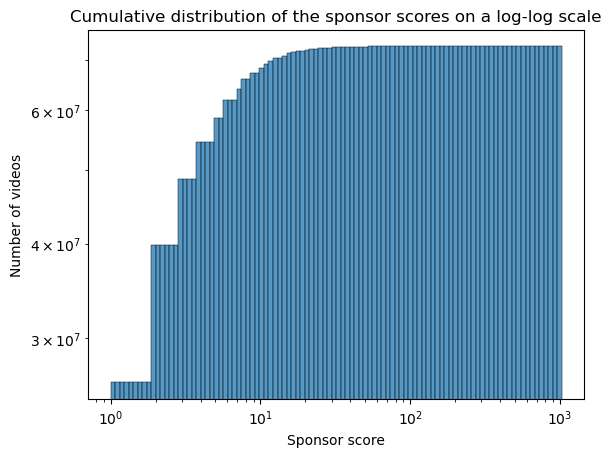

In [41]:
sns.histplot(shifted_scores, bins=100, log_scale=(True, True), cumulative=True)
plt.title("Cumulative distribution of the sponsor scores on a log-log scale")
plt.xlabel("Sponsor score")
plt.ylabel("Number of videos")
plt.show()

Note that the distribution is shifted by $1$ to have a satisfying range for the log-log plot. The great majority of videos have a sponsor score between $0$ and $10$, which seems to be a reasonable range. Many videos have a score of $0$ or $1$, which means that they might not be sponsored. A higher score might indicate that the video is sponsored, but too high of a score might be considered as an outlier.

Finally, we write the results to a parquet file.

In [13]:
PATH_METADATAS_SPONSOR_SCORES_DST = '../data/generated/yt_metadata_en_sponsor_scores.parquet'

In [14]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_SPONSOR_SCORES_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_SPONSOR_SCORES_DST -Recurse -Force" # Windows

In [15]:
metadatas_sponsor_scores.write.parquet(PATH_METADATAS_SPONSOR_SCORES_DST, mode='overwrite')